## input

In [1]:
from glob import glob

mp3_filename = glob('audio/*.mp3')[0]

print('selected %s as input' % mp3_filename)

selected audio/XC653412.mp3 as input


In [2]:
import ffmpeg

wav_filename = mp3_filename.replace('mp3', 'wav')

mp3 = ffmpeg.input(mp3_filename)
wav = ffmpeg.output(mp3, wav_filename, f='wav')
try:
    out, err = ffmpeg.run(wav, capture_stderr=True, overwrite_output=True)
    print('OK')
    print('produced', wav_filename)
except ffmpeg.Error as e:
    print(e)
    print(e.stderr)

OK
produced audio/XC653412.wav


In [3]:
from scipy.io.wavfile import read as readwav
from matplotlib import pyplot as plt

In [4]:
rate, wav = readwav(wav_filename)

In [5]:
norm = {
    'int16': 32767.
}[wav.dtype.name]

wav = wav.astype(float) / norm

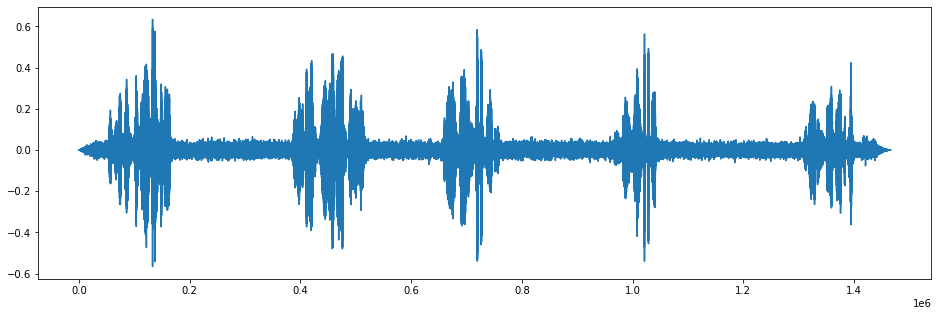

In [6]:
plt.figure(figsize=(16,5))
plt.plot(wav);

## spectrogram

In [7]:
from scipy.signal import spectrogram
import numpy as np

In [8]:
def plot_spectogram(t, f, Sxx):
    plt.figure(figsize=(26,10))
    plt.pcolormesh(t, f, Sxx, shading='auto', cmap=plt.get_cmap('Greys'))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]');

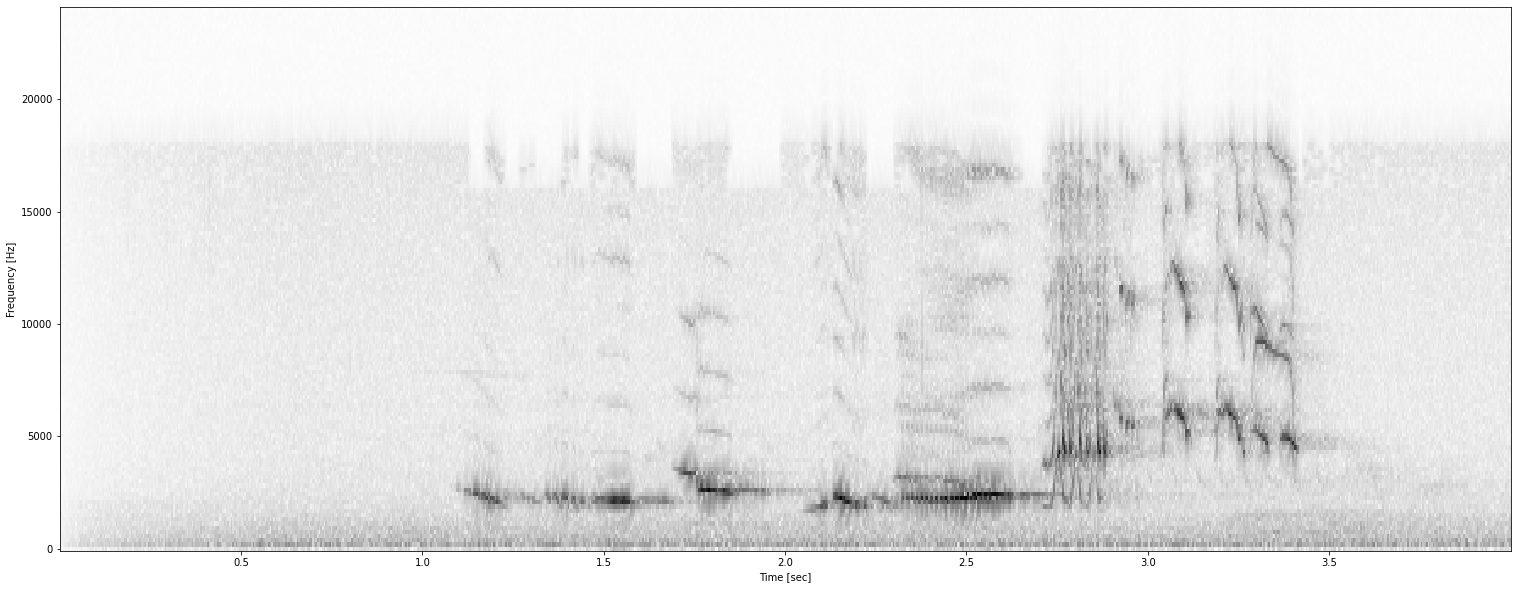

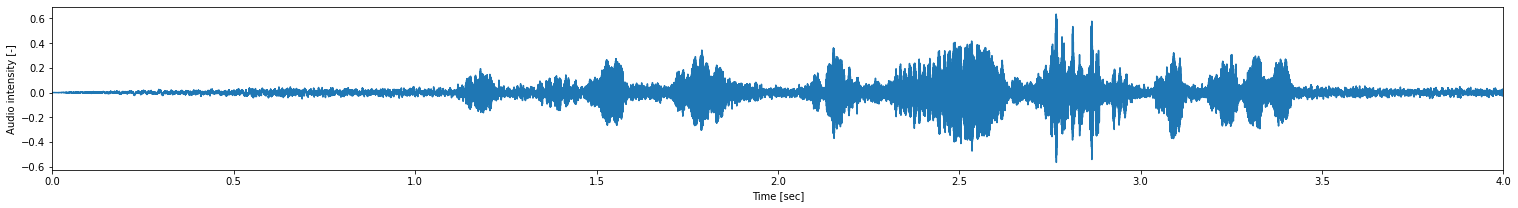

In [9]:
f, t, Sxx = spectrogram(wav[:4*rate], fs=rate)

plot_spectogram(t, f, Sxx**.125)

plt.figure(figsize=(26,3))
x = np.linspace(0., 4., 4*rate)
y = wav[:4*rate]
plt.plot(x, y)
plt.xlim(0, 4.)
plt.ylabel('Audio intensity [-]')
plt.xlabel('Time [sec]');

## classification on raw data

In [10]:
from scipy.cluster.vq import kmeans2
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter1d

In [11]:
def trim_to_15khz(f, t, Sxx):
    cutoff = np.where(f > 15e3)[0][0]
    return f[:cutoff], t, Sxx[:cutoff, :]


def plot_labeled_spectogram(f, t, Sxx, label):
    plt.figure(figsize=(26,10))
    plt.pcolormesh(t, f, Sxx, shading='auto', cmap=plt.get_cmap('Greys'))

    ax = plt.gca()
    w = t[1] - t[0]
    labels = np.unique(label)
    for l, c in zip(labels, plt.get_cmap('tab10').colors[:len(labels)]):
        for x in t[label == l]:
            ax.add_artist(Rectangle((x, 0.), width=w, height=f.max(), color=c, alpha=.3, ls=''))

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]');
    

def label_data(f, t, Sxx, N, trim=None, pre=[]):
    if trim:
        f, t, Sxx = trim(f, t, Sxx)
        
    for p in pre:
        Sxx = p(Sxx)
        
    centroid, label = kmeans2(Sxx.T, N, minit='++')
    
    return f, t, Sxx, centroid, label

        
def blur(rt=1., rf=1.):
    def _blur(Sxx):
        return gaussian_filter1d(gaussian_filter1d(Sxx, rt, axis=0), rf, axis=1)
    return _blur

In [12]:
def label_raw_data(f, t, Sxx, N):
    f, t, Sxx, centroid, label = label_data(f, t, Sxx, N, trim=trim_to_15khz, pre=[blur(rf=2.), lambda s: s**.25])
    plot_labeled_spectogram(f, t, Sxx, label)
    
    plt.figure(figsize=(26,8))
    for s, c in zip(centroid, plt.get_cmap('tab10').colors[:len(centroid)]):
        plt.plot(f, s, ls='-', c=c)

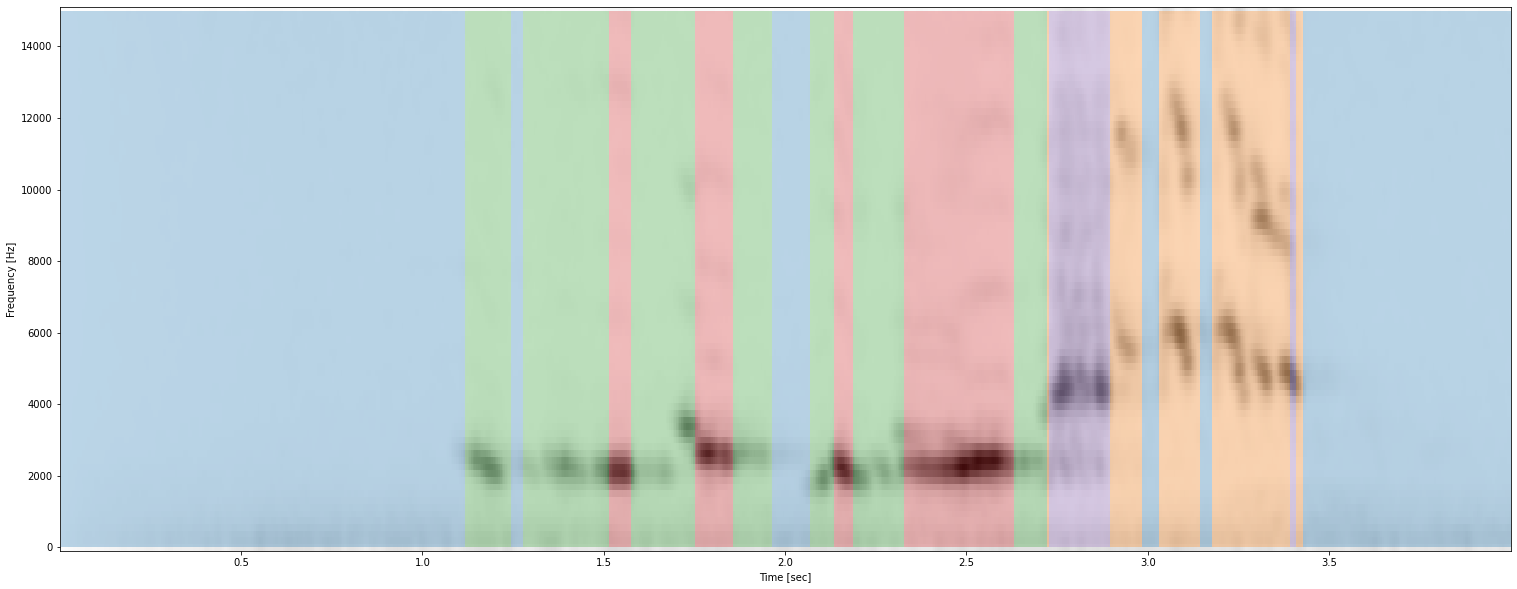

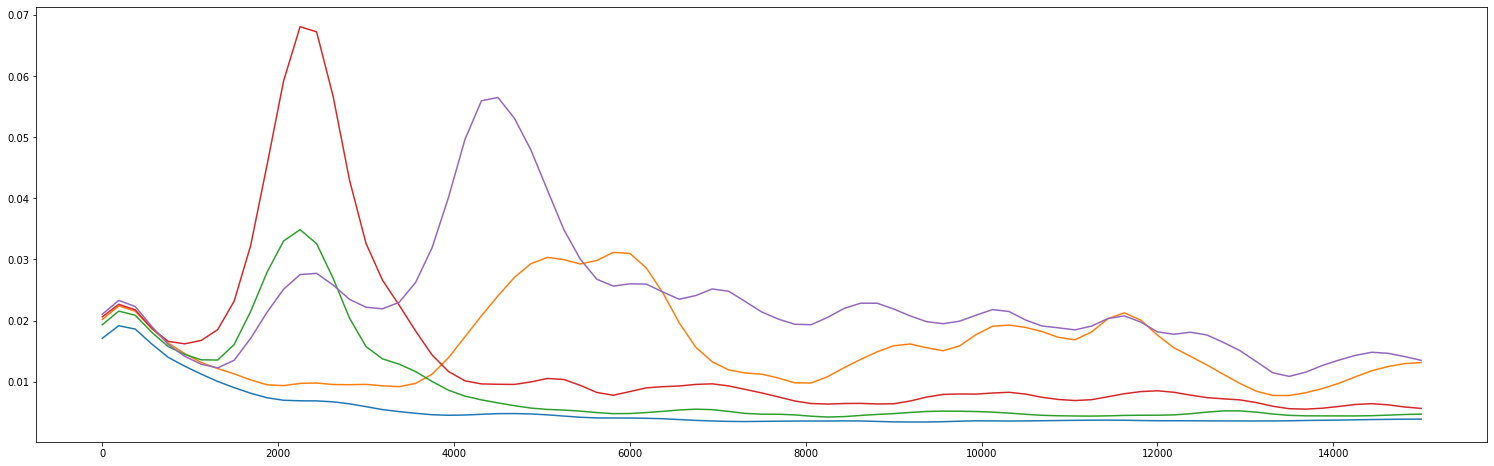

In [13]:
label_raw_data(f, t, Sxx, 5)

## classification based on features

In [14]:
def get_harmonics(y, fmin=None):
    if fmin is None:
        ff = np.argmax(y)
    else:
        ff = fmin + np.argmax(y[fmin:])
        
    LOOK_AROUND = 1
    if 2*ff + LOOK_AROUND < len(y):
        sh = 2*ff - LOOK_AROUND + np.argmax(y[2*ff - LOOK_AROUND:2*ff + LOOK_AROUND])
    else:
        sh = -1
    return ff, sh


def get_harmonic_features(y, fmin=None):
    ff, sh = get_harmonics(y, fmin=fmin)
    return y[ff], y[sh] if sh>=0 else 0.


def harmonics_for_slice(n, fmin=None):
    y = Sxx[:,n]
    plt.plot(y, 'r-')
    ff, sh = get_harmonics(y, fmin=fmin)
    plt.plot([ff, sh], y[[ff, sh]], 'bo')

In [15]:
import pandas as pd

def plot_feature(feat, name):
    plt.figure(figsize=(26,5))
    plt.title(name)
    plt.plot(t, feat, 'o')

def prep_features(f, t, Sxx, plot=False):
    f, t, Sxx = trim_to_15khz(f, t, Sxx)
    Sxx = blur(rf=2.)(Sxx)
    
    dominant_freq = np.take(f, Sxx.argmax(axis=0)) / f[-1]
    
    avg_amp = (Sxx ** 2).sum(axis=0) ** .5
    
    harmonic_amp = np.array([get_harmonic_features(y, fmin=10) for y in Sxx.T]).T
    harmonic_ff_frac = harmonic_amp[0,:] / avg_amp
    harmonic_sh_frac = harmonic_amp[1,:] / avg_amp
    
    features = pd.DataFrame({
        'power': avg_amp ** .25, 
        'dominant_freq': dominant_freq ** .5, 
        'ff_frac': harmonic_ff_frac, 
        'sh_frac': harmonic_sh_frac ** .5
    })
    features = (features - features.min()) / (features.max() - features.min())
    
    if plot:
        for c in features.columns:
            features[[c]].plot(kind='line', style='bo', figsize=(26,5), title=c, ylim=(0.,1.))
            
    return f, t, Sxx, features

In [16]:
import seaborn as sns

def label_features(f, t, Sxx, N):
    f, t, Sxx, features = prep_features(f, t, Sxx, plot=True)
    
    f, t, _, centroid, label = label_data(f, t, features.T.values, N)
    features['label'] = label
    plot_labeled_spectogram(f, t, Sxx**.25, label)
    
    sns.pairplot(features, hue='label', diag_kind="hist", palette=sns.color_palette("tab10", n_colors=len(centroid)));

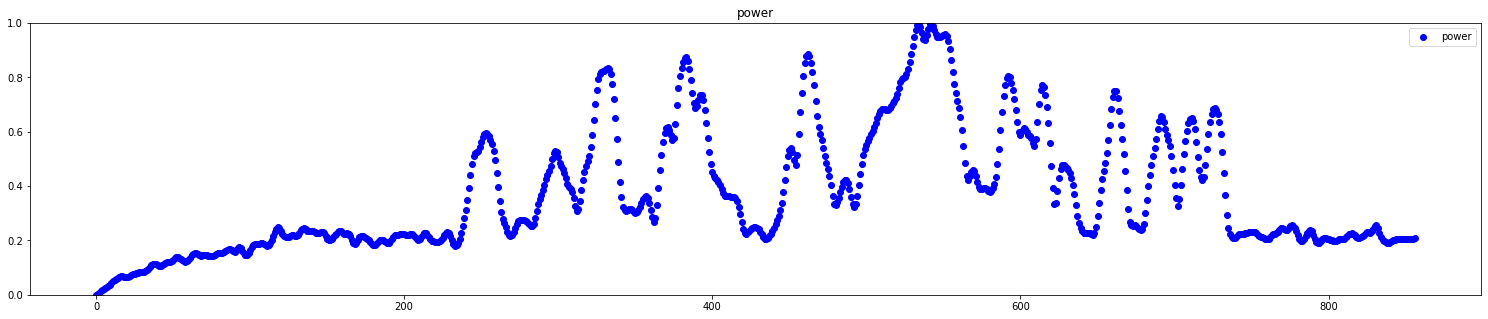

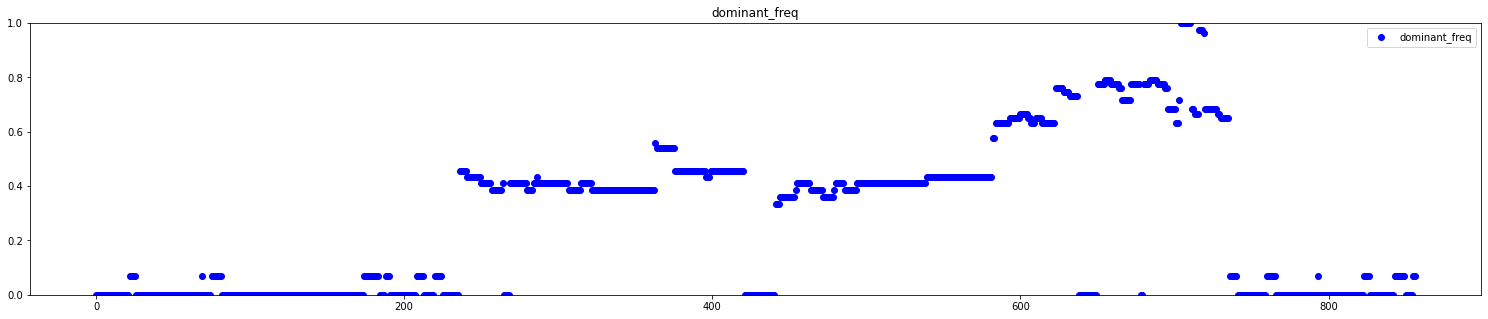

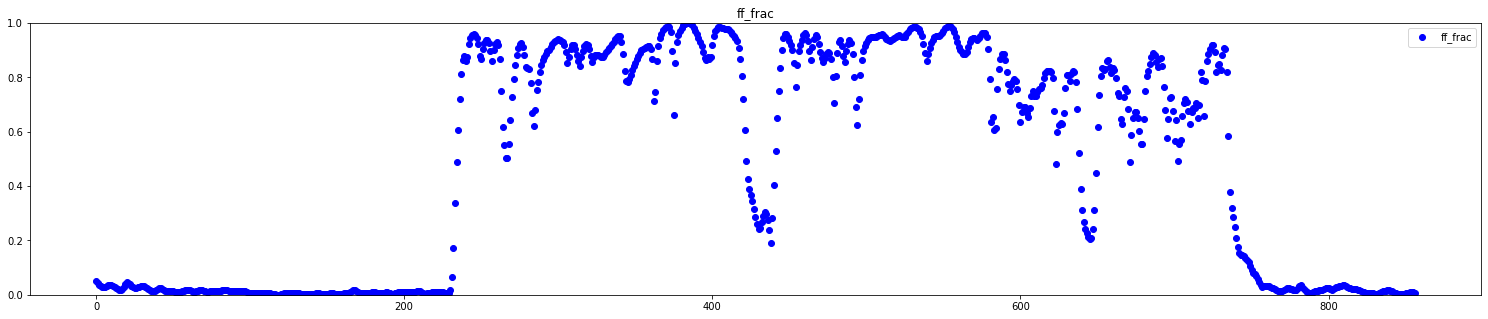

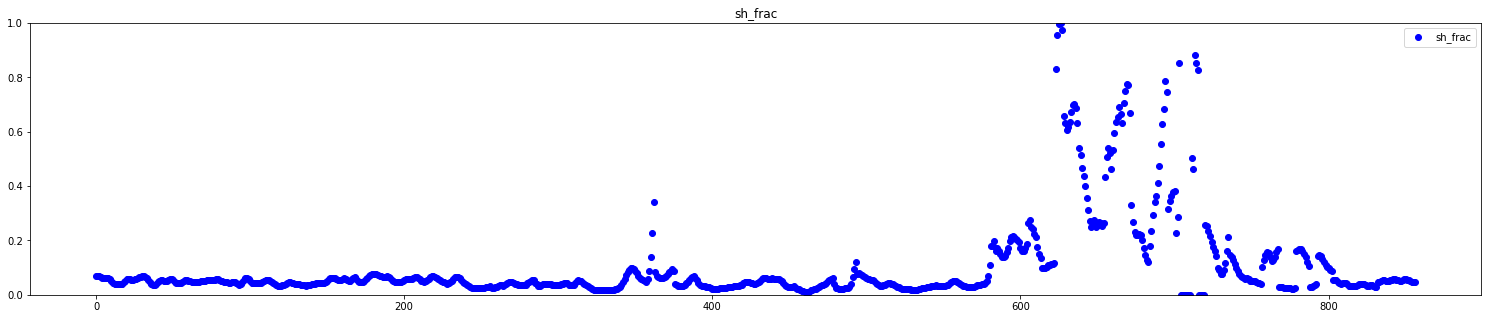

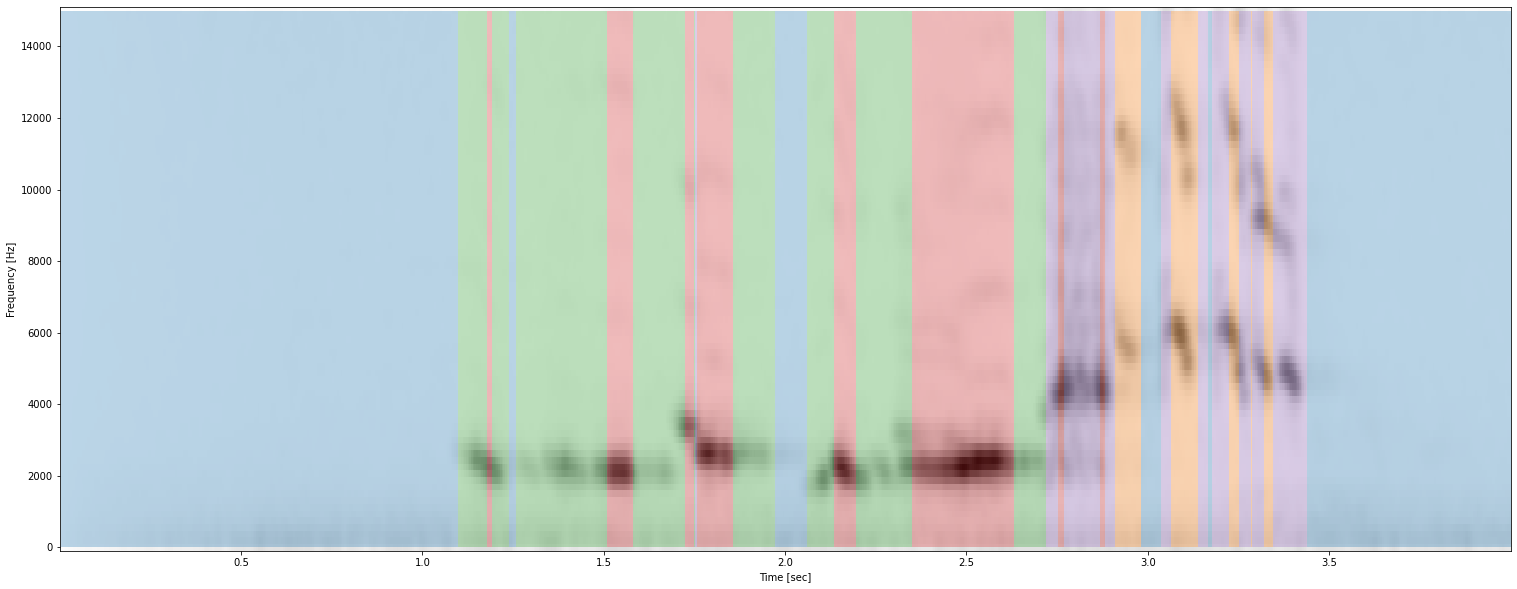

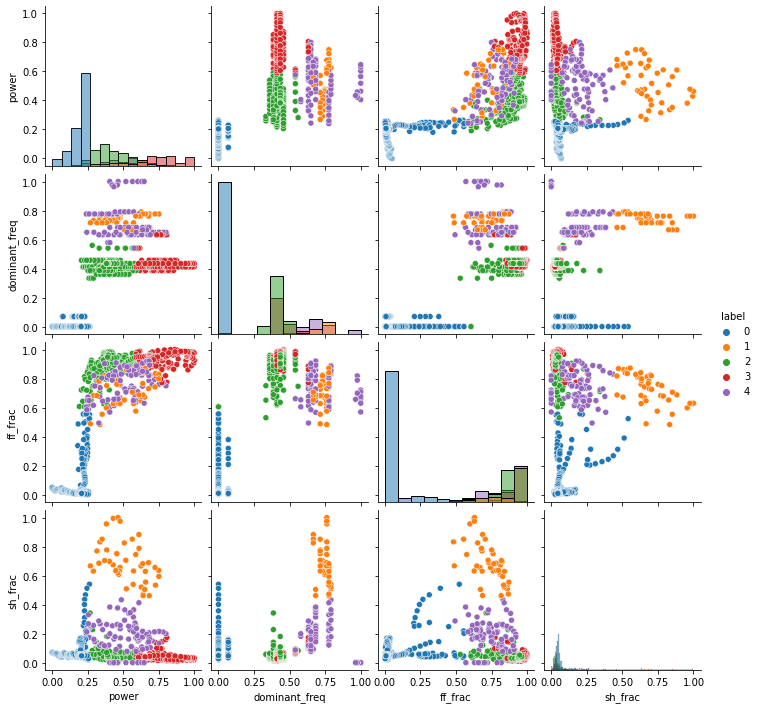

In [17]:
label_features(f, t, Sxx, 5)